In [1]:
from general_utils import *
from own_utils import *

Notebook general setup done.
Notebook general setup done.
Notebook own setup done.


In [3]:
# Corrector code

steps = 20
iterations = 3
EbN0_dB = np.linspace(0, 8, steps)
EbN0 = 10**(EbN0_dB/10)  # Convert to linear scale

EbfN0 = EbN0 * n/k
EbfN0_dB = 10 * np.log10(EbfN0)

source_ber = np.zeros(steps)  # Source bit error rate
p_canal = Q(np.sqrt(2 * EbN0 * k/n))
Pebf = ((2*tc+1)/ n) * comb(n, tc+1) * (p_canal**(tc+1)) # (using valid approximation)

for i, ebn0 in enumerate(EbN0):
    ber_sum = 0
    for _ in range(iterations):
        trials = 100 / Pebf[i] # Thumbnail rule to reach a good approximation with dynamic trials
        print("trials(ebn0)", ebn0, trials)

        source_messages = np.random.randint(0, 2, (int(trials), k), dtype=np.uint8)
        encoded_messages = np.array([encode_message(msg, G) for msg in source_messages])
        received_codewords = noisy_channel(encoded_messages, n=n, k=k, EbfN0=ebn0)
        decoded_messages = decode_message(received_codewords, H, n)

        bit_errors = np.sum(source_messages != decoded_messages[:, :k], axis=1).astype(float)
        bit_errors /= k

        ber_sum += np.mean(bit_errors)
    
    source_ber[i] = ber_sum / iterations  # Average over all 

trials(ebn0) 1.0 381.11665911272
trials(ebn0) 1.0 381.11665911272
trials(ebn0) 1.0 381.11665911272
trials(ebn0) 1.1018063301098222 466.80563560165933
trials(ebn0) 1.1018063301098222 466.80563560165933
trials(ebn0) 1.1018063301098222 466.80563560165933
trials(ebn0) 1.2139771890700746 581.1881869483482
trials(ebn0) 1.2139771890700746 581.1881869483482
trials(ebn0) 1.2139771890700746 581.1881869483482
trials(ebn0) 1.3375677515263364 736.6348100991304
trials(ebn0) 1.3375677515263364 736.6348100991304
trials(ebn0) 1.3375677515263364 736.6348100991304
trials(ebn0) 1.4737406155824793 952.0503679576201
trials(ebn0) 1.4737406155824793 952.0503679576201
trials(ebn0) 1.4737406155824793 952.0503679576201
trials(ebn0) 1.6237767391887217 1256.9826535512839
trials(ebn0) 1.6237767391887217 1256.9826535512839
trials(ebn0) 1.6237767391887217 1256.9826535512839
trials(ebn0) 1.7890874899232194 1698.7490323319057
trials(ebn0) 1.7890874899232194 1698.7490323319057
trials(ebn0) 1.7890874899232194 1698.749032

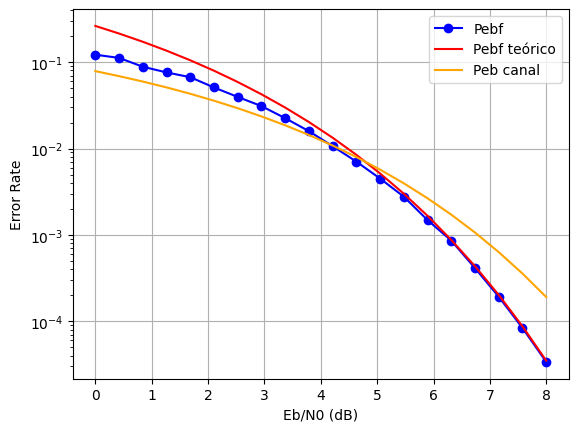

In [10]:
# Plots for corrector code

Peb = Q(np.sqrt(2 * EbN0))

plt.semilogy(EbN0_dB, source_ber, 'o-', color='blue', label='Pebf')
plt.semilogy(EbN0_dB, Pebf, 'r-', label='Pebf teórico')
plt.semilogy(EbN0_dB, Peb, '-', color='orange', label='Peb canal')

plt.plot(figsize=(14,6))
plt.grid(True)
plt.xlabel('Eb/N0 (dB)')
plt.ylabel('Error Rate')
plt.yscale('log')
plt.legend()
plt.show()

In [20]:
# Detector code

iterations = 5
dsteps = 10
EbN0_dB = np.linspace(0, 6, dsteps)
EbN0 = 10**(EbN0_dB/10)  # Convert to linear scale

# Simulate error rates for coded system, only with error detection
coded_wer = np.zeros(dsteps)  # Coded word error rate
p_canal = Q(np.sqrt(2 * EbN0 * k/n)) 
Pew = comb(n, td+1) * (p_canal**(td+1)) # (using valid approximation)

for i, eb_n0 in enumerate(EbN0):
    trials = 100 / Pew[i] # Thumbnail rule to reach a good approximation with dynamic trials
    print("trials(eb_n0)", eb_n0, trials)

    ber_sum = 0
    for _ in range(iterations): 
        source_messages = np.random.randint(0, 2, (int(trials), k))

        encoded_messages = np.array([encode_message(msg, G) for msg in source_messages])
        received_codewords = noisy_channel(encoded_messages, n=n, k=k, EbfN0=eb_n0)
        
        syndromes = np.dot(received_codewords, H.T) % 2
        detected = ~np.any(syndromes, axis=1)  # True for undetected errors

        # Get only the undetected error cases
        Ve = received_codewords[detected] # Received codewords with undetected errors
        U = source_messages[np.where(detected)[0]] # Original source messages for undetected errors
        
        Ue = Ve[:, :k] # First k bits of received codewords
        E = U != Ue # Bit differences
        bit_differences = np.sum(E, axis=1) # Sum of bit errors per word
        word_errors = (bit_differences > 0).astype(float) # Word errors
        
        ber_sum += np.mean(word_errors)

    coded_wer[i] = ber_sum / iterations

trials(eb_n0) 1.0 176.0100363201134
trials(eb_n0) 1.1659144011798317 288.12596943471135
trials(eb_n0) 1.3593563908785256 503.2313658821766
trials(eb_n0) 1.5848931924611136 946.9387726997318
trials(eb_n0) 1.847849797422291 1941.6241395651566
trials(eb_n0) 2.154434690031884 4395.682754645108
trials(eb_n0) 2.51188643150958 11157.830487899331
trials(eb_n0) 2.928644564625236 32329.94468778801
trials(eb_n0) 3.4145488738336014 109187.55520163443
trials(eb_n0) 3.9810717055349722 440417.55388747586


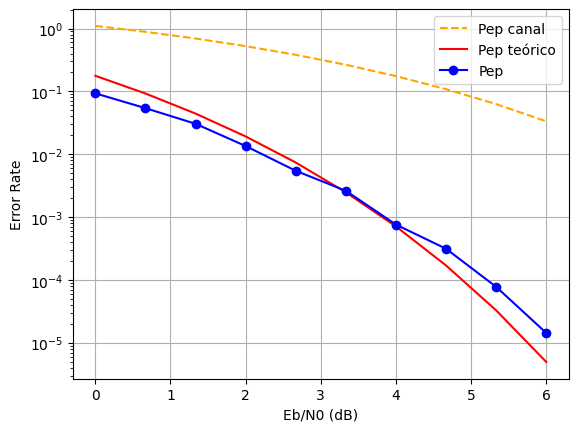

In [ ]:
# Plots for corrector code

Peb = Q(np.sqrt(2 * EbN0))
Pew_sc = n * Peb
p_teorico = Q(np.sqrt(2 * EbN0)) 
Pew_teorico = comb(n, td+1) * (p_teorico**(td+1)) # (using valid approximation)

plt.semilogy(EbN0_dB, Pew_sc, '-', color='orange', label='Pep canal')
plt.semilogy(EbN0_dB, Pew_teorico, 'r-', label='Pep teórico')
plt.semilogy(EbN0_dB, coded_wer, 'o-', color='blue', label='Pep')

plt.plot(figsize=(14,6))
plt.grid(True)
plt.xlabel('Eb/N0 (dB)')
plt.ylabel('Error Rate')
plt.yscale('log')
plt.legend()
plt.show()